In [6]:
using JuMP, Cbc, Distances, Distributions, CairoMakie

LoadError: ArgumentError: Package JuMP not found in current path:
- Run `import Pkg; Pkg.add("JuMP")` to install the JuMP package.


In [2]:
n_fac = 2
n_clients_1 = 3
n_clients_2 = 3

3

In [3]:
coordinates = [
    2 3
    4 3
    1 5
    3 5
    5 5
    1 1
    3 1
    5 1
];

In [4]:
d = pairwise(Euclidean(), coordinates, dims=1);

LoadError: UndefVarError: Euclidean not defined

In [5]:
for i in 1:size(d)[1]
    d[i,i] = 9999999
end

LoadError: UndefVarError: d not defined

In [6]:
q = rand(Normal(30,5), size(d)[1]);
q[1:n_fac] .= 0;
#[0 0 1 1 1]

In [7]:
C = [500, 500, 500];

In [8]:
K = 1

1

In [9]:
function LRP(d, q, C)
    m = Model(Cbc.Optimizer)
    @variable(m, y[i in 1:n_fac], Bin)
    @variable(m, x[i in 1:n_fac+n_clients_1, j in 1:n_fac+n_clients_1, k in 1:K], Bin)
    @variable(m, w[i in 1:n_fac+n_clients_2, j in 1:n_fac+n_clients_2, k in 1:K], Bin)
    
    @objective(m, Min, 
        sum(y) + 
        sum(d[i,j] * sum(x[i,j,k] for k in 1:K) for i in 1:n_fac+n_clients_1, j in 1:n_fac+n_clients_1)+
        sum(d[i,j] * sum(w[i,j,k] for k in 1:K) for i in 1:n_fac+n_clients_2, j in 1:n_fac+n_clients_2)
    )
    
    
    #Level 1 constraints
    @constraint(m, [i in 1:n_fac+n_clients_1, k in 1:K], sum(x[i,j,k] for j in 1:n_fac+n_clients_1) == 1)
    @constraint(m, [i in 1:n_fac, j in 1:n_fac, k in 1:K], x[i,j,k] == 0)
    @constraint(m, [i in 1:n_fac+n_clients_1, k in 1:K], 
        sum(x[i,j,k] for j in 1:n_fac+n_clients_1) - sum(x[j,i,k] for j in 1:n_fac+n_clients_1) == 0)
    @constraint(m, [i in n_fac+1:n_clients_1, k in 1:K], q[i] * sum(x[i,j,k] for j in 1:n_fac+n_clients_1) <= C[k])
    
    @constraint(m, [i in 1:n_fac, k in 1:K], 
        sum(x[i,1:n_fac+n_clients_1,k]) + sum(x[1:n_fac+n_clients_1,i,k]) - y[i] <= 1)
    
    #Level 2 constraints
    @constraint(m, [i in 1:n_fac+n_clients_2, k in 1:K], sum(w[i,j,k] for j in 1:n_fac+n_clients_2) == 1)
    @constraint(m, [i in 1:n_fac, j in 1:n_fac, k in 1:K], w[i,j,k] == 0)
    @constraint(m, [i in 1:n_fac+n_clients_2, k in 1:K], 
        sum(w[i,j,k] for j in 1:n_fac+n_clients_2) - sum(w[j,i,k] for j in 1:n_fac+n_clients_2) == 0)
    @constraint(m, [i in n_fac+1:n_clients_2, k in 1:K], q[i] * sum(w[i,j,k] for j in 1:n_fac+n_clients_2) <= C[k])
    
    @constraint(m, [i in 1:n_fac, k in 1:K], 
        sum(w[i,1:n_fac+n_clients_2,k]) + sum(w[1:n_fac+n_clients_2,i,k]) - y[i] <= 1)
    
    optimize!(m)
    
    x_sol = JuMP.value.(x)
    w_sol = JuMP.value.(w)
    y_sol = JuMP.value.(y)
    
    return x_sol, w_sol, y_sol
    
end

LRP (generic function with 1 method)

In [10]:
x_sol, w_sol, y_sol = LRP(d,q,C);

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Nov  9 2020 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 23.8885 - 0.00 seconds
Cgl0002I 8 variables fixed
Cgl0004I processed model has 24 rows, 44 columns (44 integer (44 of which binary)) and 142 elements
Cbc0012I Integer solution of 23.888544 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 23.88854381999832, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from 23.8885 to 23.8885
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Clique 

In [11]:
function selected_edges(x::Array{Float64}, n)
    return Tuple{Int,Int}[(j,i) for i in 1:n, j in 1:n if x[i, j] > 0.5]
end

selected_edges (generic function with 1 method)

In [12]:
function trace_route(edges, coordinates, tier)
    
    if tier == 1 
        x = hcat([coordinates[i,:] for (i,j) in edges]...)'
        y = hcat([coordinates[j,:] for (i,j) in edges]...)'
    else
        x = hcat([i <= n_fac ? coordinates[i,:] : coordinates[i+n_clients_1,:] for (i,j) in edges]...)'
        y = hcat([j <= n_fac ? coordinates[j,:] : coordinates[j+n_clients_1,:] for (i,j) in edges]...)'
    end
    
    x,y
end

trace_route (generic function with 1 method)

In [13]:
edges_1 = selected_edges(x_sol, size(x_sol, 1));
edges_2 = selected_edges(w_sol, size(w_sol, 1));

In [14]:
route_x_1, route_y_1 = trace_route(edges_1, coordinates, 1);
route_x_2, route_y_2 = trace_route(edges_2, coordinates, 2);

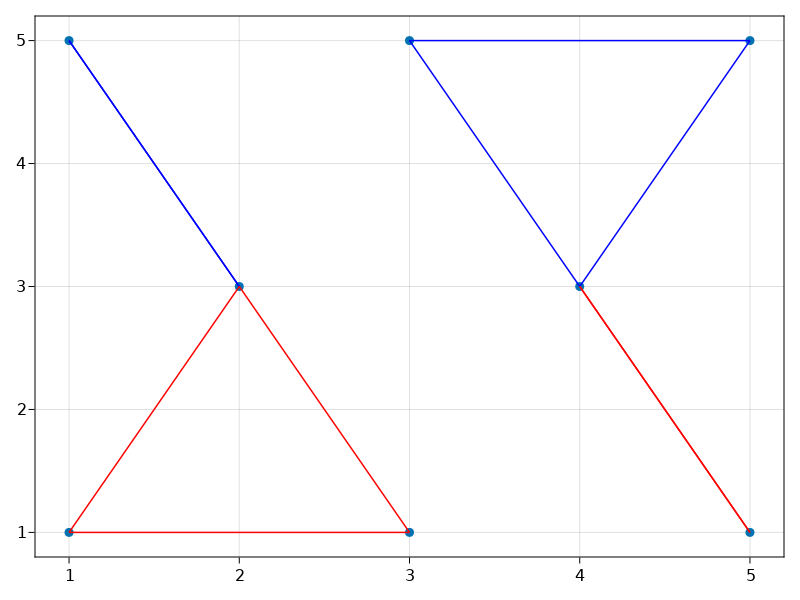

In [15]:
CairoMakie.scatter(coordinates)

for i in 1:n_fac+n_clients_1
    lines!([route_x_1[i,1], route_y_1[i,1]], [route_x_1[i,2], route_y_1[i,2]], color = :blue)
end

for i in 1:n_fac+n_clients_2
    lines!([route_x_2[i,1], route_y_2[i,1]], [route_x_2[i,2], route_y_2[i,2]], color = :red)
end

current_figure()